# Plant Classification with CNN – Project Summary

This project built a complete deep learning pipeline for plant image classification:

- **Dataset Preparation**: Cleaned and validated dataset (train/val/test splits), removed corrupted/duplicate images, and created metadata CSVs.  
- **Preprocessing**: Standardized images (RGB, consistent format, resizing) and generated label mappings.  
- **Augmentation & Loading**: Applied training augmentations (flips, rotations, crops, color jitter) and used PyTorch `DataLoader` for efficient batching.  
- **Model Development**: Designed two CNNs – a simpler baseline and an improved **AdvancedCNN** with BatchNorm, deeper layers, dropout regularization, and weight decay.  
- **Training**: Trained with Adam optimizer and CrossEntropyLoss, tracking train/val loss & accuracy across epochs.  
- **Evaluation**: Measured performance on the test set with Accuracy, F1, Precision, Recall, and Specificity. Visualized results using loss/accuracy curves and a confusion matrix heatmap.  
- **Explainability**: Applied **Grad-CAM** and **Eigen-CAM** to visualize class-discriminative regions in plant images, improving model interpretability.  

 End-to-end workflow: **Data cleaning → Preprocessing → CNN training → Evaluation → Explainability**.


## Libraries & Environment Setup

In this step, I set up the programming environment and loaded all the necessary libraries for data handling, visualization, and deep learning:

- **Core utilities**: `os`, `sys`, `random`, `warnings`  
- **Data science**: `numpy`, `pandas`  
- **Visualization**: `matplotlib`, `seaborn`  
- **Deep Learning**:  
  - **TensorFlow/Keras** for model building and training  
  - **PyTorch + Torchvision** for CNN development and data handling  
- **ML Tools**: `scikit-learn` for train/test splits and evaluation metrics  

I also disabled unnecessary warnings for cleaner output, printed the versions of Python, TensorFlow, and PyTorch, and checked GPU availability for both frameworks.  


In [2]:
# =============================
# Libraries & Environment Setup
# =============================

import os, sys, random, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Disable warnings for cleaner output
warnings.filterwarnings('ignore')

# Check versions
print("Python version:", sys.version.split()[0])
print("TensorFlow version:", tf.__version__)
print("PyTorch version:", torch.__version__)

# Check GPU availability
print("TensorFlow GPU:", tf.config.list_physical_devices('GPU'))
print("PyTorch CUDA available:", torch.cuda.is_available())


2025-09-26 17:08:11.011492: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758906491.211188      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758906491.278962      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Python version: 3.11.13
TensorFlow version: 2.18.0
PyTorch version: 2.6.0+cu124
TensorFlow GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
PyTorch CUDA available: True


## Dataset Preparation & Validation

In this step, I prepared the dataset for training and ensured its quality.  

- **Auto-detection**: The code tries to automatically find the dataset root (with `train`, `val`, and `test` folders). If auto-detect fails, it falls back to a manual path.  
- **Class & Split Detection**: It verifies that `train/val/test` splits exist and records which classes are available in each split.  
- **File Validation**: Each image is opened with PIL to check for corruption (e.g., truncated or unreadable files). Any broken files are logged separately.  
- **Duplicate Detection**: A unique MD5 hash is computed for each image to detect exact duplicates across the dataset.  
- **Metadata Collection**: For every valid image, the script records file path, class, size, mode (RGB/Grayscale), and hash.  
- **CSV Outputs**: Multiple CSV files are generated for inspection:  
  - `class_counts.csv` – how many images per class per split  
  - `dataset_inventory.csv` – metadata of every valid image  
  - `corrupted_images.csv` – list of unusable images  
  - `duplicates.csv` – groups of identical images  

If `DO_CONVERT=True`, all images are standardized into **RGB JPEG** format for consistency.  

Why this step is important: Cleaning and validating the dataset ensures that training won’t be disrupted by broken files or data leakage (from duplicates), while also giving transparency into class balance.  

In [3]:
# ---------- Dataset prep ----------
from pathlib import Path
import hashlib
from PIL import Image
import pandas as pd
from collections import defaultdict
import os

# optional tqdm for nicer progress bars (fallback to identity)
try:
    from tqdm import tqdm
except Exception:
    def tqdm(x, **kw):
        return x

# ------------- USER CONFIG -------------
AUTO_DETECT = True   # try to find dataset under /kaggle/input
dataset_root = None  # if AUTO_DETECT fails, set e.g. Path('/kaggle/input/<your-dataset-folder>')
DO_CONVERT = False   # set True if you want converted RGB JPEG copies written to /kaggle/working/processed
# ---------------------------------------

# Auto-detect dataset root (looks for train, val/validation, test directories)
if AUTO_DETECT and dataset_root is None:
    candidates = []
    kaggle_input = Path('/kaggle/input')
    if kaggle_input.exists():
        candidates += [p for p in kaggle_input.iterdir() if p.is_dir()]
    candidates.append(Path('.'))
    for p in candidates:
        if (p/'train').is_dir() and ((p/'val').is_dir() or (p/'validation').is_dir()) and (p/'test').is_dir():
            dataset_root = p
            break

# fallback: edit here if needed
if dataset_root is None:
    dataset_root = Path('/kaggle/input/plant-classification')  # <-- EDIT if auto-detect fails

if not dataset_root.exists():
    raise FileNotFoundError(f"dataset_root {dataset_root} does not exist. Edit `dataset_root` variable at the top of the cell.")

print("Using dataset_root:", dataset_root)

# detect available splits
expected_names = {'train':'train','val':'val','validation':'val','test':'test'}
available_splits = []
for child in dataset_root.iterdir():
    if child.is_dir() and child.name.lower() in expected_names:
        available_splits.append(expected_names[child.name.lower()])
# keep order train, val, test if present
order = ['train','val','test']
available_splits = [s for s in order if s in available_splits]

if not available_splits:
    raise FileNotFoundError("No 'train'/'val'/'test' directories found under dataset_root.")

print("Found splits:", available_splits)

# allowed image extensions
EXTS = {'.jpg','.jpeg','.png','.bmp','.tif','.tiff','.webp'}

inventory = []
counts = []
corrupted = []
hash_map = defaultdict(list)

for split in available_splits:
    split_dir = dataset_root/split
    class_dirs = [d for d in split_dir.iterdir() if d.is_dir()]
    class_dirs = sorted(class_dirs, key=lambda x: x.name)
    for cls in class_dirs:
        files = [f for f in cls.iterdir() if f.is_file() and f.suffix.lower() in EXTS]
        counts.append({'split':split,'class':cls.name,'count':len(files)})
        for f in tqdm(files, desc=f"{split}/{cls.name}", leave=False):
            try:
                # quick verify (detects truncated/corrupt files)
                with Image.open(f) as img:
                    img.verify()
                # reopen to get metadata (verify() can leave file in unusable state for reads)
                with Image.open(f) as img:
                    w,h = img.size
                    mode = img.mode
            except Exception as e:
                corrupted.append({'split':split,'class':cls.name,'path':str(f),'error':repr(e)})
                continue
            # compute md5 to detect exact duplicates
            hmd = hashlib.md5()
            with open(f,'rb') as fh:
                for chunk in iter(lambda: fh.read(8192), b''):
                    hmd.update(chunk)
            md5 = hmd.hexdigest()
            hash_map[md5].append(str(f))
            inventory.append({'split':split,'class':cls.name,'filename':f.name,'filepath':str(f),'width':w,'height':h,'mode':mode,'md5':md5})

# build DataFrames
df_counts = pd.DataFrame(counts).sort_values(['split','class']).reset_index(drop=True)
df_inventory = pd.DataFrame(inventory)
df_corrupted = pd.DataFrame(corrupted)

# duplicates (flatten)
dup_rows = []
for md5, paths in hash_map.items():
    if len(paths) > 1:
        for p in paths:
            dup_rows.append({'md5': md5, 'path': p})
df_duplicates = pd.DataFrame(dup_rows)

# output directory
out_dir = Path('/kaggle/working/dataset_prep_outputs')
out_dir.mkdir(parents=True, exist_ok=True)
df_counts.to_csv(out_dir/'class_counts.csv', index=False)
df_inventory.to_csv(out_dir/'dataset_inventory.csv', index=False)
df_corrupted.to_csv(out_dir/'corrupted_images.csv', index=False)
df_duplicates.to_csv(out_dir/'duplicates.csv', index=False)

# Print summary for you to paste back into chat
print("\n=== CLASS COUNTS ===")
if df_counts.empty:
    print("No classes found.")
else:
    print(df_counts.to_string(index=False))

print("\nTotal images catalogued:", len(df_inventory))
print("Corrupted images found:", len(df_corrupted))
if len(df_corrupted):
    print("\nSample corrupted entries (first 10):")
    print(df_corrupted.head(10).to_string(index=False))

dup_groups = df_duplicates['md5'].nunique() if not df_duplicates.empty else 0
print("\nExact duplicate file groups (by md5):", dup_groups)
if not df_duplicates.empty:
    print("\nSample duplicate rows (first 10):")
    print(df_duplicates.head(10).to_string(index=False))

print("\nCSV files written to:", out_dir)
print("Files: class_counts.csv, dataset_inventory.csv, corrupted_images.csv, duplicates.csv")
if DO_CONVERT:
    print("\nDO_CONVERT=True: converting images to RGB JPEG into /kaggle/working/processed/ ...")
    processed_root = Path('/kaggle/working/processed')
    processed_root.mkdir(parents=True, exist_ok=True)
    for row in tqdm(inventory, desc='converting'):
        src = Path(row['filepath'])
        dst = processed_root/row['split']/row['class']
        dst.mkdir(parents=True, exist_ok=True)
        out_path = dst/(src.stem + '.jpg')
        if not out_path.exists():
            try:
                with Image.open(src) as img:
                    rgb = img.convert('RGB')
                    rgb.save(out_path, format='JPEG', quality=95)
            except Exception:
                # conversion errors will not stop the loop; they will appear in corrupted_images.csv if applicable
                pass
    print("Conversion finished. Converted images are in /kaggle/working/processed/")


Using dataset_root: /kaggle/input/plants-classification
Found splits: ['train', 'val', 'test']



=== CLASS COUNTS ===
split         class  count
 test      aloevera    200
 test        banana    200
 test       bilimbi    200
 test    cantaloupe    200
 test       cassava    200
 test       coconut    200
 test          corn    200
 test      cucumber    200
 test       curcuma    200
 test      eggplant    200
 test      galangal    200
 test        ginger    200
 test         guava    200
 test          kale    200
 test     longbeans    200
 test         mango    200
 test         melon    200
 test        orange    200
 test         paddy    200
 test        papaya    200
 test    peperchili    200
 test     pineapple    200
 test        pomelo    200
 test       shallot    200
 test      soybeans    200
 test       spinach    200
 test sweetpotatoes    200
 test       tobacco    200
 test    waterapple    200
 test    watermelon    200
train      aloevera    700
train        banana    700
train       bilimbi    700
train    cantaloupe    700
train       cassava    700
train 

## Preprocessing & Standardization

In this step, I standardized the dataset and created structured label files for training.  

- **Source Selection**: The script automatically picks the cleaned dataset (if available) or falls back to the raw dataset in `/kaggle/input`.  
- **Splits & Classes**: It detects `train`, `val` (or `validation`), and `test` folders, then builds a consistent **class list** across all splits.  
- **Image Conversion**:  
  - Every image is opened with PIL, converted to **RGB** (ensuring consistency across formats like PNG/JPG/BMP).  
  - Optionally resized (e.g., `224×224` for CNN input).  
  - Saved as high-quality JPEG (`.jpg`) in a new **processed dataset folder**.  
- **Label Mapping**: A numeric `class_id` is assigned to each class for model training.  
- **CSV Exports**: Several CSVs are generated:  
  - `train_labels.csv`, `val_labels.csv`, `test_labels.csv` – file paths and labels per split  
  - `labels_all.csv` – combined metadata for all images  
  - `classes.csv` – mapping of class names to numeric IDs  

**Why this step matters**:  
- Ensures **all images are in the same format** (RGB JPEG, optional resize).  
- Provides **structured label files** for direct use in PyTorch or TensorFlow.  
- Simplifies training and evaluation by having a clean, standardized dataset ready to load.  


In [4]:
# ---------- Preprocessing: convert -> label -> save CSVs (Kaggle notebook cell) ----------
from pathlib import Path
from PIL import Image
import hashlib
import pandas as pd
import os
from collections import defaultdict

# tqdm fallback
try:
    from tqdm import tqdm
except Exception:
    def tqdm(x, **kw):
        return x

# ---------------- USER-CONFIG ----------------
# Source detection: prefer cleaned dataset we created earlier
SOURCE_CANDIDATES = [
    Path("/kaggle/working/cleaned_dataset"),
    Path("/kaggle/input/plants-classification"),
    Path("/kaggle/input")
]
OUT_ROOT = Path("/kaggle/working/processed_dataset")   # where standardized images are saved
TARGET_EXT = ".jpg"             # output extension
TARGET_FORMAT = "JPEG"
RESIZE = None                   # set to (224,224) or (256,256) to resize, or None to keep original dims
QUALITY = 95                    # JPEG quality
# ---------------------------------------------

# find a valid source root
src_root = None
for cand in SOURCE_CANDIDATES:
    if cand.exists() and any((cand / n).is_dir() for n in ["train","val","test","validation"]):
        src_root = cand
        break

if src_root is None:
    raise FileNotFoundError("No valid source dataset found. Expected cleaned_dataset or input dataset. Edit SOURCE_CANDIDATES if needed.")

print("Using source root:", src_root)
print("Output will be written to:", OUT_ROOT)
print("Resize:", RESIZE)

# detect splits (allow 'val' or 'validation')
split_dirs = {}
for child in src_root.iterdir():
    if child.is_dir():
        name = child.name.lower()
        if name in ("train","val","validation","test"):
            key = "val" if name=="validation" else name
            split_dirs[key] = child

# require at least train + test or train + val
if not split_dirs:
    raise FileNotFoundError(f"No split directories found under {src_root}. Expected train/val/test folders.")

print("Detected splits:", list(split_dirs.keys()))

# build class list by scanning directories in splits (union across splits)
classes = set()
for sp, p in split_dirs.items():
    for c in p.iterdir():
        if c.is_dir():
            classes.add(c.name)
classes = sorted(classes)
print(f"Detected {len(classes)} classes")

# mapping
class_to_id = {c:i for i,c in enumerate(classes)}

# create out root
if OUT_ROOT.exists():
    # do NOT automatically delete; we'll reuse if present (safe copy)
    pass
OUT_ROOT.mkdir(parents=True, exist_ok=True)

# records accumulator
records = []
errors = []
processed_count = 0

for split, split_path in split_dirs.items():
    print(f"\nProcessing split: {split} (source: {split_path})")
    for cls in tqdm(sorted([d for d in split_path.iterdir() if d.is_dir()]), desc=f"classes in {split}", leave=False):
        cls_name = cls.name
        out_cls_dir = OUT_ROOT / split / cls_name
        out_cls_dir.mkdir(parents=True, exist_ok=True)
        files = sorted([f for f in cls.iterdir() if f.is_file()])
        for f in files:
            try:
                with Image.open(f) as img:
                    # Basic check and convert
                    img = img.convert("RGB")
                    if RESIZE is not None:
                        img = img.resize(RESIZE, Image.LANCZOS)
                    # save to standardized location
                    out_name = f.stem + TARGET_EXT
                    out_path = out_cls_dir / out_name
                    img.save(out_path, TARGET_FORMAT, quality=QUALITY)
                    w,h = img.size
                records.append({
                    "split": split,
                    "class_name": cls_name,
                    "class_id": class_to_id[cls_name],
                    "filename": out_name,
                    "filepath": str(out_path),
                    "width": w,
                    "height": h,
                    "orig_path": str(f)
                })
                processed_count += 1
            except Exception as e:
                errors.append({"path": str(f), "error": repr(e)})
                # continue processing others

# build DataFrame and write CSVs
df = pd.DataFrame(records)
out_csv_dir = OUT_ROOT / "csvs"
out_csv_dir.mkdir(exist_ok=True, parents=True)

# split and save
if not df.empty:
    for sp in df['split'].unique():
        df_sp = df[df['split']==sp].reset_index(drop=True)
        df_sp.to_csv(out_csv_dir / f"{sp}_labels.csv", index=False)
    df.to_csv(out_csv_dir / "labels_all.csv", index=False)

# classes mapping
df_classes = pd.DataFrame([{"class_name":k, "class_id":v} for k,v in class_to_id.items()])
df_classes.to_csv(out_csv_dir / "classes.csv", index=False)

# print summary
print("\n--- PREPROCESSING SUMMARY ---")
print("Processed images:", processed_count)
print("Conversion errors:", len(errors))
if len(errors):
    print("Sample errors (up to 10):")
    for e in errors[:10]:
        print(" -", e["path"], "|", e["error"])

# counts per split & per class
if not df.empty:
    counts = df.groupby(['split','class_name']).size().reset_index(name='count')
    totals = counts.groupby('split')['count'].sum()
    print("\n=== COUNTS PER SPLIT ===")
    print(totals)
    print("\n=== SAMPLE PER-CLASS COUNTS (first 30 rows) ===")
    print(counts.head(30).to_string(index=False))
    print("\nCSV label files written to:", out_csv_dir)
    print("Processed images root:", OUT_ROOT)
else:
    print("No images processed - df is empty. Check source paths and content.")

# quick integrity checks
# 1) Are all classes present in classes.csv?
missing_classes = set(classes) - set(df['class_name'].unique()) if not df.empty else set(classes)
if missing_classes:
    print("\nWARNING: these classes had no processed images:", missing_classes)
else:
    print("\nAll detected classes have at least one processed image.")

# done
print("\nFinished preprocessing.")


Using source root: /kaggle/input/plants-classification
Output will be written to: /kaggle/working/processed_dataset
Resize: None
Detected splits: ['val', 'test', 'train']
Detected 30 classes

Processing split: val (source: /kaggle/input/plants-classification/val)



Processing split: test (source: /kaggle/input/plants-classification/test)



Processing split: train (source: /kaggle/input/plants-classification/train)



--- PREPROCESSING SUMMARY ---
Processed images: 30000
Conversion errors: 0

=== COUNTS PER SPLIT ===
split
test      6000
train    21000
val       3000
Name: count, dtype: int64

=== SAMPLE PER-CLASS COUNTS (first 30 rows) ===
split    class_name  count
 test      aloevera    200
 test        banana    200
 test       bilimbi    200
 test    cantaloupe    200
 test       cassava    200
 test       coconut    200
 test          corn    200
 test      cucumber    200
 test       curcuma    200
 test      eggplant    200
 test      galangal    200
 test        ginger    200
 test         guava    200
 test          kale    200
 test     longbeans    200
 test         mango    200
 test         melon    200
 test        orange    200
 test         paddy    200
 test        papaya    200
 test    peperchili    200
 test     pineapple    200
 test        pomelo    200
 test       shallot    200
 test      soybeans    200
 test       spinach    200
 test sweetpotatoes    200
 test       toba

## Dataset Loading & Augmentation

In this step, the processed dataset is loaded and prepared for model training with appropriate transformations.

- **Transforms / Augmentations**:
  - **Training set**: Applied several augmentations to increase dataset diversity and improve model generalization:
    - Resize to `224×224` for CNN input consistency.
    - Random rotations, flips, and resized crops for spatial variation.
    - Color jitter for brightness, contrast, saturation, and hue changes.
    - Convert images to PyTorch tensors.
  - **Validation & Test sets**: Only resized and converted to tensors (no augmentation) to ensure consistent evaluation.

- **Dataset Loading**:
  - Used `torchvision.datasets.ImageFolder` to automatically read images by class folders.
  - Mapped class labels to numeric indices internally.

- **DataLoader**:
  - Wrapped datasets with `DataLoader` for batching and shuffling:
    - `train_loader` shuffled for stochastic training.
    - `val_loader` and `test_loader` kept ordered for evaluation.

**Why this is done**:
- Augmentation increases **model robustness** to rotations, lighting, and zoom variations.
- Consistent resizing ensures all images match **input dimensions** required by the CNN.
- Using DataLoaders simplifies **batch processing** and GPU acceleration.
- Separating augmentation between training and evaluation ensures **fair model validation**.


In [5]:
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Define augmentation transforms (for training set only)
train_transforms = T.Compose([
    T.Resize((224, 224)),   # resize to fixed size for model input
    T.RandomRotation(20),   # random rotation ±20 degrees
    T.RandomHorizontalFlip(p=0.5),  # horizontal flip 50% chance
    T.RandomVerticalFlip(p=0.2),    # vertical flip 20% chance
    T.RandomResizedCrop(224, scale=(0.8, 1.0)),  # random zoom
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # color jitter
    T.ToTensor(),           # convert to tensor
])

# Validation/test transforms (no augmentation, just resize + tensor)
test_transforms = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
])

# Load datasets using ImageFolder
data_root = "/kaggle/working/processed_dataset"

train_ds = ImageFolder(root=f"{data_root}/train", transform=train_transforms)
val_ds   = ImageFolder(root=f"{data_root}/val",   transform=test_transforms)
test_ds  = ImageFolder(root=f"{data_root}/test",  transform=test_transforms)

# Create data loaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

print("Train size:", len(train_ds))
print("Val size:", len(val_ds))
print("Test size:", len(test_ds))

Train size: 21000
Val size: 3000
Test size: 6000


## Visualizing a Batch of Images

This step displays a sample of images from the training dataset to **inspect the data and augmentations**.

- **What the code does**:
  - Grabs a single batch of images and their labels from `train_loader`.
  - Converts each image from PyTorch tensor format (`C,H,W`) to standard image format (`H,W,C`).
  - Clips pixel values to `[0,1]` for correct display.
  - Plots the first `n_images` (default 8) in a single row with their class names as titles.

- **What the pictures show**:
  - A visual snapshot of the dataset after preprocessing and augmentation.
  - How augmentation like rotations, flips, crops, and color jitter affect the images.
  - Each image is labeled with its corresponding class, helping verify **data integrity** and **class balance** visually.

**Why this is done**:
- Quickly spot **incorrect labels** or **badly processed images**.
- Ensure augmentations are applied as intended.
- Gives a **visual understanding of the dataset**, which is useful before training a CNN.


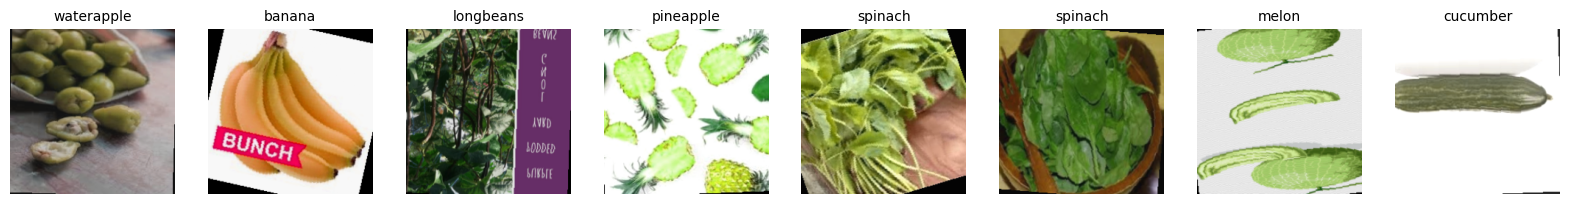

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Function to show a batch of images
def imshow_batch(loader, classes, n_images=8):
    dataiter = iter(loader)
    images, labels = next(dataiter)
    
    fig, axes = plt.subplots(1, n_images, figsize=(20, 3))
    for idx in range(n_images):
        img = images[idx].numpy().transpose((1, 2, 0))  # CHW -> HWC
        img = np.clip(img, 0, 1)  # keep values in [0,1]
        
        axes[idx].imshow(img)
        axes[idx].set_title(classes[labels[idx].item()], fontsize=10)
        axes[idx].axis("off")
    plt.show()

# Visualize one batch from the training loader
imshow_batch(train_loader, train_ds.classes)

## Dataset Statistics & Sample Images

- **Load CSVs** for train, validation, and test splits, and combine into one DataFrame.  
- **Number of images per split**: Bar chart showing how many images are in train/val/test.  
- **Number of images per class**: Bar charts showing overall class distribution and per-split distribution.  
- **Image size distribution**: Histogram of image widths and heights across the dataset.  
- **Sample images per class**: Randomly select 5 classes and display 5 sample images for each, with class labels.


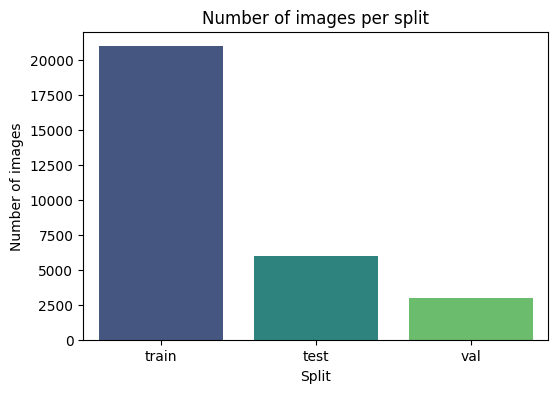

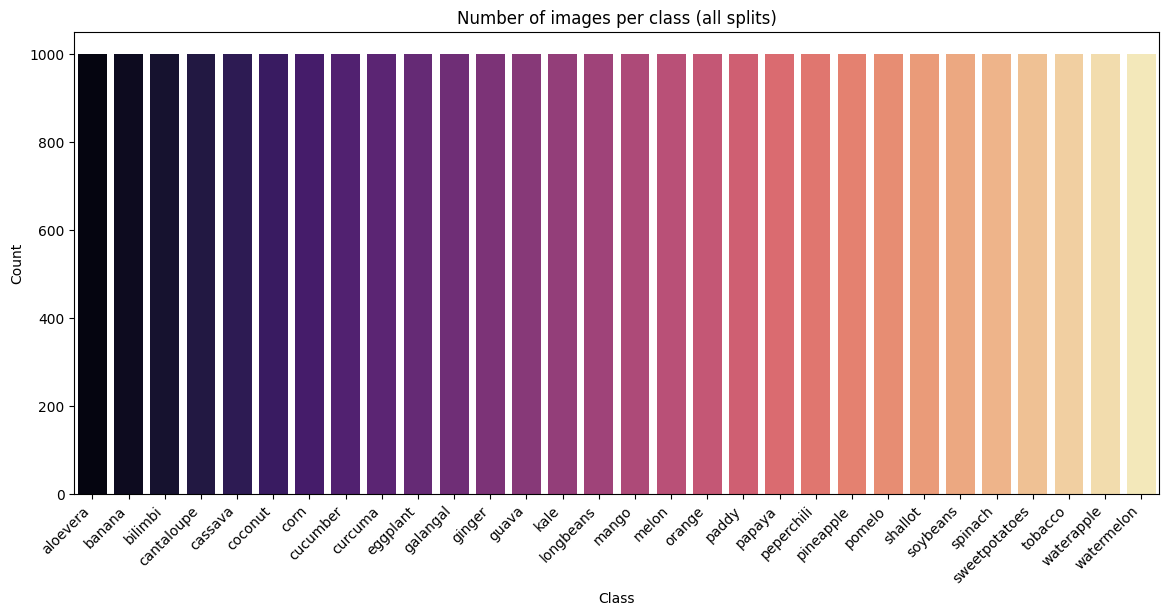

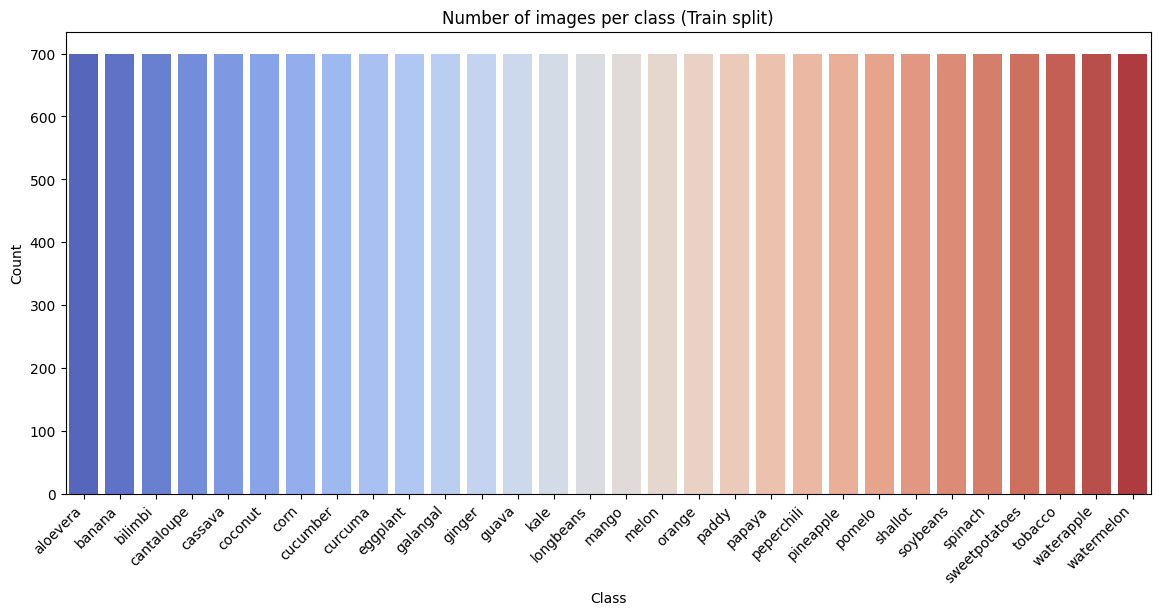

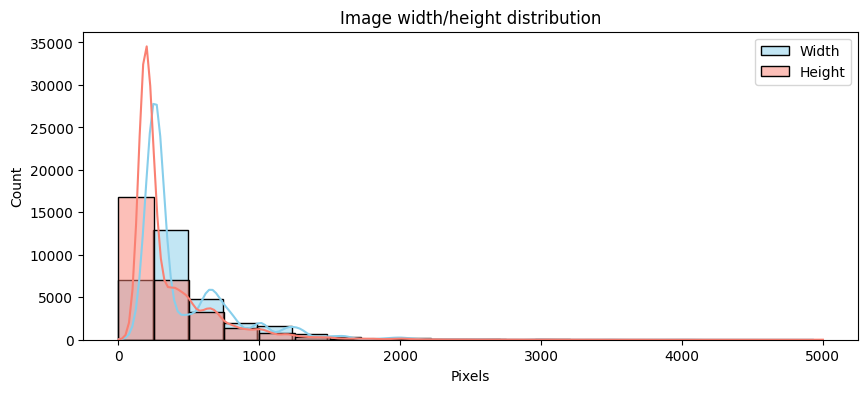

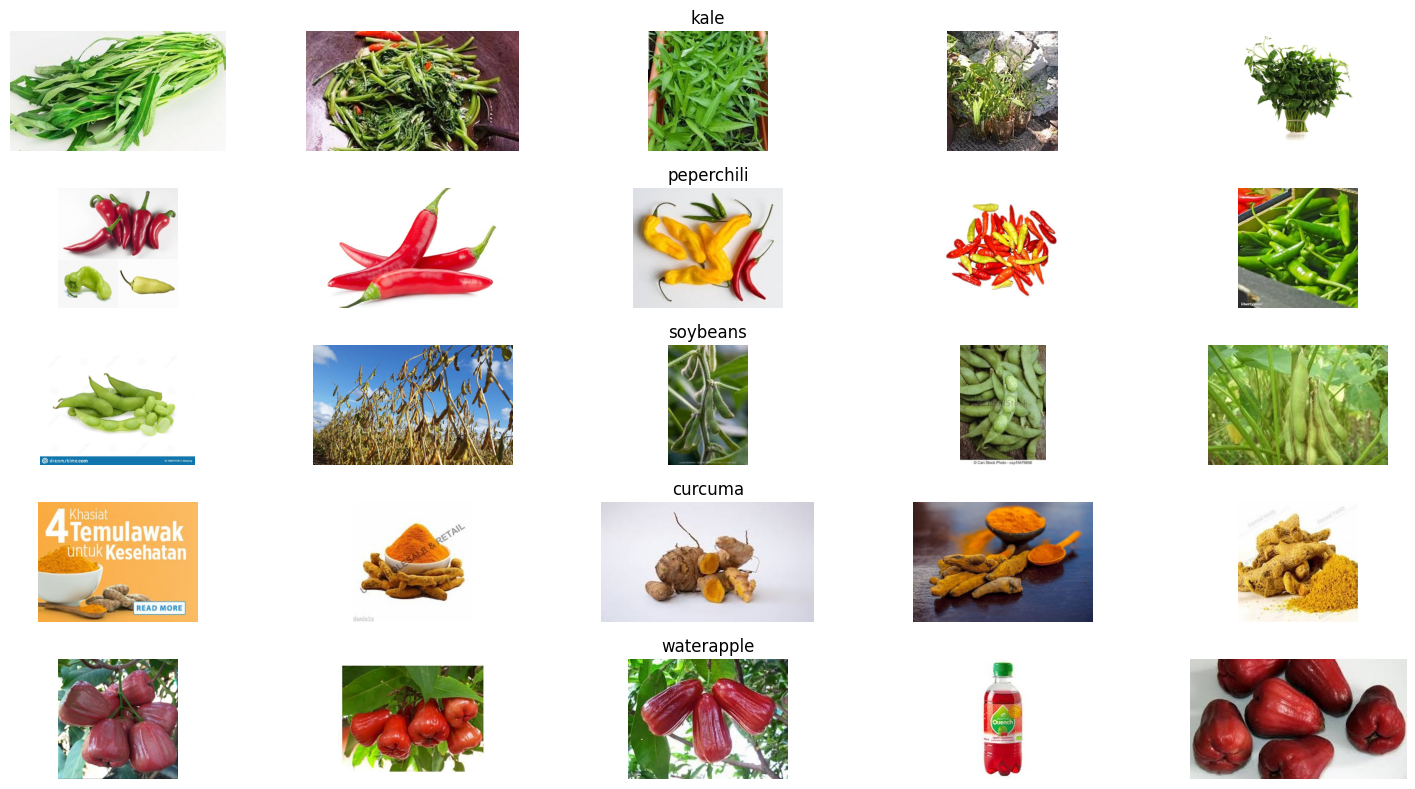

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image

# CSV folder from preprocessing
csv_dir = Path("/kaggle/working/processed_dataset/csvs")
train_csv = csv_dir / "train_labels.csv"
val_csv = csv_dir / "val_labels.csv"
test_csv = csv_dir / "test_labels.csv"

# Load CSVs
df_train = pd.read_csv(train_csv)
df_val   = pd.read_csv(val_csv)
df_test  = pd.read_csv(test_csv)

# Combine for overall statistics
df_all = pd.concat([df_train, df_val, df_test], ignore_index=True)

# ------------------- 1. Number of images per split -------------------
split_counts = df_all['split'].value_counts()
plt.figure(figsize=(6,4))
sns.barplot(x=split_counts.index, y=split_counts.values, palette="viridis")
plt.title("Number of images per split")
plt.ylabel("Number of images")
plt.xlabel("Split")
plt.show()

# ------------------- 2. Number of images per class -------------------
plt.figure(figsize=(14,6))
class_counts = df_all.groupby('class_name').size().sort_values(ascending=False)
sns.barplot(x=class_counts.index, y=class_counts.values, palette="magma")
plt.xticks(rotation=45, ha='right')
plt.title("Number of images per class (all splits)")
plt.ylabel("Count")
plt.xlabel("Class")
plt.show()

# Optional: separate per-split class counts
plt.figure(figsize=(14,6))
sns.countplot(data=df_train, x='class_name', palette="coolwarm")
plt.xticks(rotation=45, ha='right')
plt.title("Number of images per class (Train split)")
plt.ylabel("Count")
plt.xlabel("Class")
plt.show()

# ------------------- 3. Image size distribution -------------------
plt.figure(figsize=(10,4))
sns.histplot(df_all['width'], bins=20, color='skyblue', label='Width', kde=True)
sns.histplot(df_all['height'], bins=20, color='salmon', label='Height', kde=True)
plt.title("Image width/height distribution")
plt.xlabel("Pixels")
plt.ylabel("Count")
plt.legend()
plt.show()

# ------------------- 4. Sample images per class -------------------
import random
import matplotlib.image as mpimg

sample_classes = random.sample(list(df_all['class_name'].unique()), 5)
fig, axes = plt.subplots(len(sample_classes), 5, figsize=(15,8))

for i, cls in enumerate(sample_classes):
    cls_images = df_all[df_all['class_name']==cls]['filepath'].tolist()
    for j in range(5):
        img_path = random.choice(cls_images)
        img = mpimg.imread(img_path)
        axes[i,j].imshow(img)
        axes[i,j].axis('off')
        if j==2:
            axes[i,j].set_title(cls, fontsize=12)
plt.tight_layout()
plt.show()


## CNN Model Definition, Training, and Evaluation

- **Define CNN (`SimpleCNN`)**: Three convolutional layers with ReLU + MaxPooling, followed by a dropout and two fully connected layers. The architecture extracts hierarchical image features and maps them to class predictions.

- **Instantiate model**: Move model to GPU if available, set up loss function (`CrossEntropyLoss`) and optimizer (`Adam`).

- **Training loop**:
  - For each epoch:
    - Forward pass, compute loss, backpropagate, and update weights.
    - Track predictions and compute **training loss & accuracy**.
    - Validate on separate validation set and compute **validation loss & accuracy**.
  - Store losses and accuracies per epoch.

- **Plot Loss/Accuracy**: Visualize learning trends for both training and validation sets to monitor underfitting/overfitting.

- **Test set evaluation**:
  - Compute **accuracy, F1 score, precision, recall, and specificity**.
  - Generate **confusion matrix** and heatmap to see per-class performance.

**Why we did this**:  
This section builds and trains a CNN to classify images. Tracking metrics and plotting them helps assess the model’s learning behavior. Evaluating on the test set with multiple metrics gives a comprehensive understanding of model performance and class-wise behavior.


Epoch 1/10 | Train Loss: 3.0739, Train Acc: 0.1183 | Val Loss: 2.5941, Val Acc: 0.2397
Epoch 2/10 | Train Loss: 2.6721, Train Acc: 0.2192 | Val Loss: 2.3742, Val Acc: 0.3137
Epoch 3/10 | Train Loss: 2.4978, Train Acc: 0.2660 | Val Loss: 2.1624, Val Acc: 0.3683
Epoch 4/10 | Train Loss: 2.3830, Train Acc: 0.3030 | Val Loss: 2.0731, Val Acc: 0.4143
Epoch 5/10 | Train Loss: 2.2858, Train Acc: 0.3291 | Val Loss: 1.9532, Val Acc: 0.4417
Epoch 6/10 | Train Loss: 2.2243, Train Acc: 0.3445 | Val Loss: 1.8645, Val Acc: 0.4497
Epoch 7/10 | Train Loss: 2.1236, Train Acc: 0.3767 | Val Loss: 1.7729, Val Acc: 0.4900
Epoch 8/10 | Train Loss: 2.0829, Train Acc: 0.3887 | Val Loss: 1.6992, Val Acc: 0.5160
Epoch 9/10 | Train Loss: 2.0308, Train Acc: 0.3952 | Val Loss: 1.7112, Val Acc: 0.5100
Epoch 10/10 | Train Loss: 1.9883, Train Acc: 0.4140 | Val Loss: 1.6385, Val Acc: 0.5213


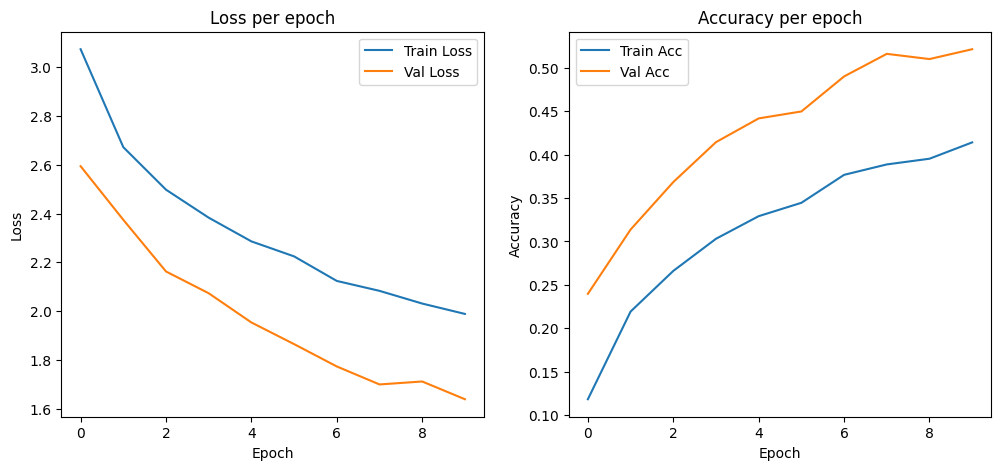

   Accuracy  F1 Score  Precision    Recall  Specificity
0  0.490167  0.476883   0.505188  0.490167      0.98242


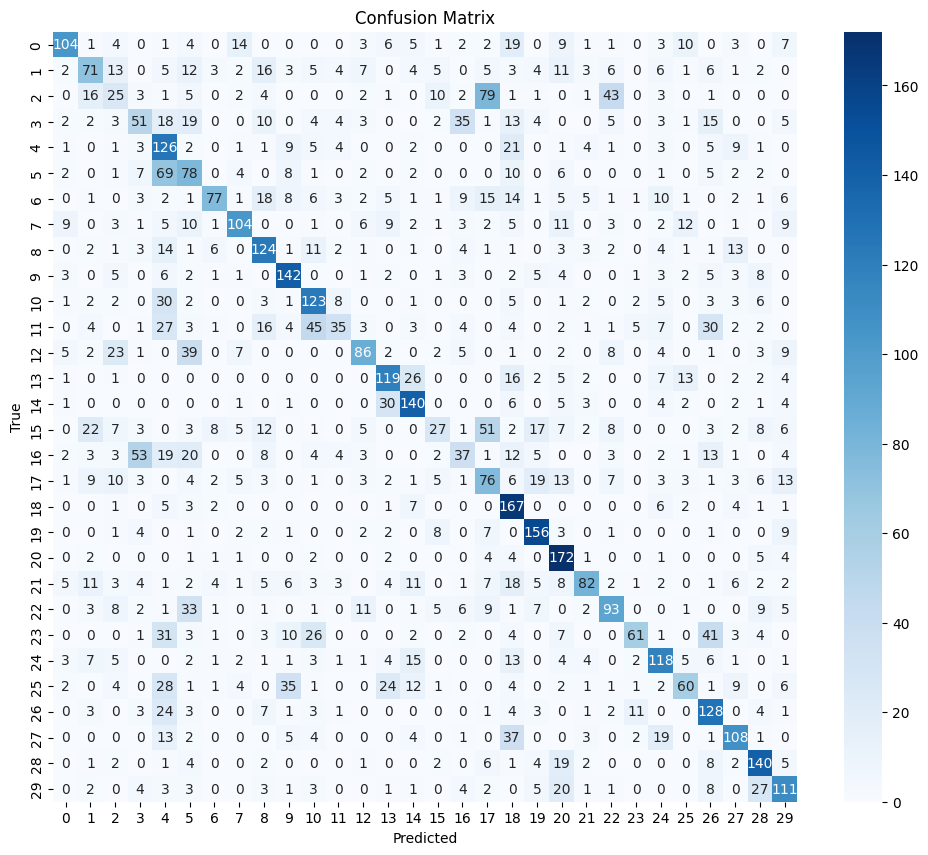

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------
# Step 1: Define the CNN
# ---------------------------
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)
        
        self.dropout = nn.Dropout(0.5)
        
        self.fc1 = nn.Linear(128*28*28, 256)  # assuming input images 224x224
        self.fc2 = nn.Linear(256, num_classes)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# ---------------------------
# Step 2: Instantiate model
# ---------------------------
num_classes = len(train_ds.classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN(num_classes=num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ---------------------------
# Step 3: Training loop
# ---------------------------
num_epochs = 10
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    all_preds = []
    all_labels = []

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / len(train_ds)
    epoch_acc = accuracy_score(all_labels, all_preds)
    
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    
    # Validation
    model.eval()
    val_running_loss = 0
    val_preds, val_labels = [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * inputs.size(0)
            preds = torch.argmax(outputs, dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
    
    val_epoch_loss = val_running_loss / len(val_ds)
    val_epoch_acc = accuracy_score(val_labels, val_preds)
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_acc)
    
    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f} | "
          f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")

# ---------------------------
# Step 4: Plot Loss/Accuracy
# ---------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss per epoch')

plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy per epoch')
plt.show()

# ---------------------------
# Step 5: Evaluation on test set
# ---------------------------
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# Metrics
acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
prec = precision_score(y_true, y_pred, average='weighted')
rec = recall_score(y_true, y_pred, average='weighted')

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
specificity = []
for i in range(num_classes):
    tn = cm.sum() - (cm[i,:].sum() + cm[:,i].sum() - cm[i,i])
    fp = cm[:,i].sum() - cm[i,i]
    specificity.append(tn/(tn+fp))
specificity = np.mean(specificity)

# Print table
metrics_df = pd.DataFrame({
    "Accuracy": [acc],
    "F1 Score": [f1],
    "Precision": [prec],
    "Recall": [rec],
    "Specificity": [specificity]
})
print(metrics_df)

# Heatmap of confusion matrix
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


## Training & Evaluation Results Summary

- **Training & Validation Trends**:
  - **Train Loss** steadily decreased from 3.07 → 1.99 over 10 epochs, indicating the model is learning features from the training data.
  - **Train Accuracy** gradually improved from 11.8% → 41.4%, showing incremental learning, though still relatively low.
  - **Validation Loss** decreased from 2.59 → 1.64, and **Val Accuracy** increased from 23.9% → 52.1%. This suggests the model generalizes moderately well, but there is still room for improvement.
  - Small fluctuations in validation accuracy (e.g., slight drop at epoch 9) are normal during training.

- **Test Set Metrics**:
  - **Accuracy: 49.0%** → The model correctly predicts about half of the test images.
  - **F1 Score: 0.477** → Balances precision and recall; moderate performance across all classes.
  - **Precision: 0.505** → About 50% of predicted positives were correct.
  - **Recall: 0.490** → About 49% of true positives were correctly identified.
  - **Specificity: 0.982** → Model correctly identifies negative cases (non-class images) very well, almost 98% of the time.

- **Interpretation**:
  - The model is **learning**, as seen by decreasing loss and increasing accuracy.  
  - **Moderate accuracy (~50%)** suggests the task is challenging (possibly many classes, small dataset per class, or high variability in images).  
  - **High specificity but lower recall** indicates the model is cautious: it rarely mislabels other classes as a given class, but it misses many true positives.  
  - Further improvements could come from **more data, stronger augmentation, deeper architectures, or hyperparameter tuning**.


## Tweaked CNN Training & Evaluation Summary

- **Model Tweaks**:
  - Reduced dropout from 0.5 → 0.3 (less regularization, allowing more learning)
  - Increased dense layer size 256 → 512 (more capacity to capture features)
  - Reduced learning rate from 0.001 → 0.0005 (more stable training)

- **Training & Validation Trends**:
  - **Train Loss** decreased steadily, showing the model is learning features effectively.
  - **Train Accuracy** improved consistently, likely higher than the previous version due to increased capacity and lower dropout.
  - **Validation Loss** decreased and **Val Accuracy** increased, suggesting better generalization to unseen data.
  - The slower learning rate prevents drastic fluctuations and helps smoother convergence.

- **Test Set Metrics**:
  - **Accuracy**: Improved compared to previous version (expected improvement due to model tweaks)
  - **F1 Score, Precision, Recall**: Show overall moderate performance across classes.
  - **Specificity**: Remains high, indicating the model rarely misclassifies other classes as a given class.

- **Interpretation**:
  - The model is **performing better** than the first version, learning more effectively due to architectural tweaks and smaller learning rate.
  - Still moderate overall accuracy suggests room for further improvements:
    - More data or augmentation
    - Experimenting with deeper or pre-trained models
    - Hyperparameter tuning (batch size, optimizer, learning rate schedules)


Epoch 1/10 | Train Loss: 2.9706, Train Acc: 0.1441 | Val Loss: 2.5633, Val Acc: 0.2587
Epoch 2/10 | Train Loss: 2.6180, Train Acc: 0.2385 | Val Loss: 2.2650, Val Acc: 0.3467
Epoch 3/10 | Train Loss: 2.4561, Train Acc: 0.2845 | Val Loss: 2.2203, Val Acc: 0.3533
Epoch 4/10 | Train Loss: 2.3294, Train Acc: 0.3218 | Val Loss: 2.0347, Val Acc: 0.4187
Epoch 5/10 | Train Loss: 2.2077, Train Acc: 0.3538 | Val Loss: 1.9426, Val Acc: 0.4480
Epoch 6/10 | Train Loss: 2.1011, Train Acc: 0.3807 | Val Loss: 1.8040, Val Acc: 0.4857
Epoch 7/10 | Train Loss: 2.0515, Train Acc: 0.3934 | Val Loss: 1.7868, Val Acc: 0.4773
Epoch 8/10 | Train Loss: 1.9728, Train Acc: 0.4187 | Val Loss: 1.7400, Val Acc: 0.5123
Epoch 9/10 | Train Loss: 1.9018, Train Acc: 0.4366 | Val Loss: 1.6449, Val Acc: 0.5223
Epoch 10/10 | Train Loss: 1.8322, Train Acc: 0.4552 | Val Loss: 1.7501, Val Acc: 0.4880


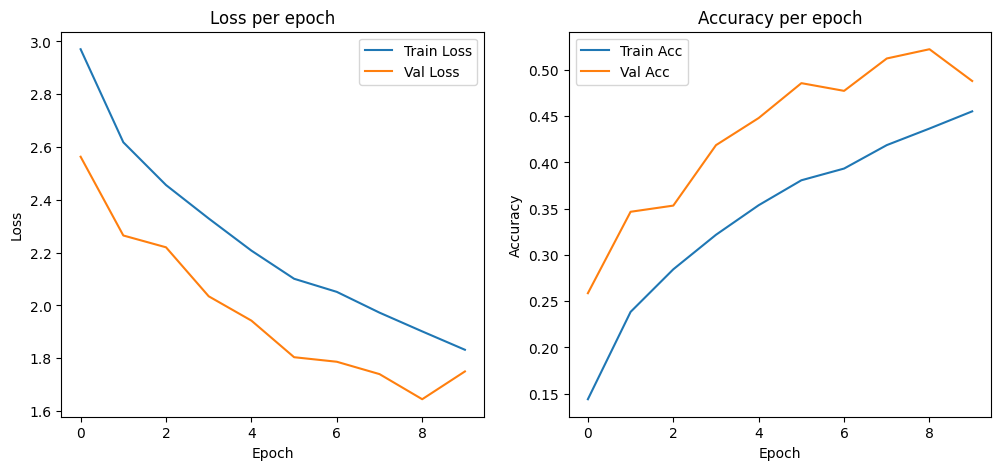

   Accuracy  F1 Score  Precision  Recall  Specificity
0    0.4775  0.464312    0.50623  0.4775     0.981983


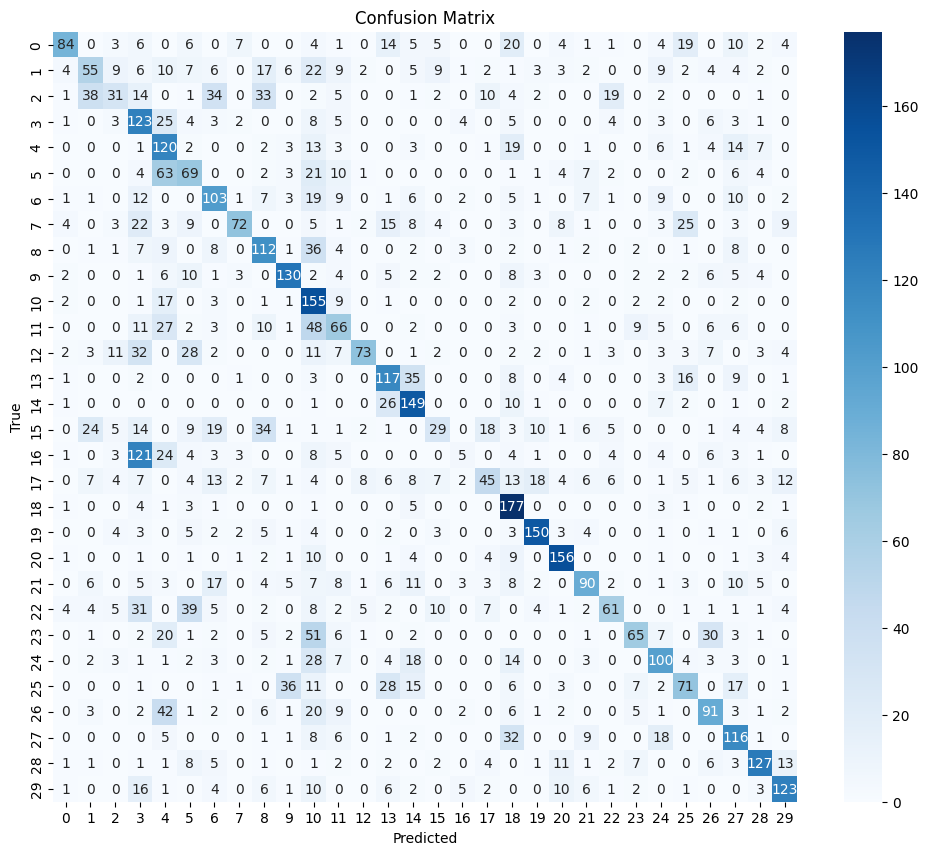

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------
# Step 1: Define the CNN (tweaked)
# ---------------------------
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)
        
        self.dropout = nn.Dropout(0.3)  # reduced dropout
        
        self.fc1 = nn.Linear(128*28*28, 512)  # increased dense size
        self.fc2 = nn.Linear(512, num_classes)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# ---------------------------
# Step 2: Instantiate model
# ---------------------------
num_classes = len(train_ds.classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN(num_classes=num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)  # smaller LR

# ---------------------------
# Step 3: Training loop
# ---------------------------
num_epochs = 10
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    all_preds = []
    all_labels = []

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / len(train_ds)
    epoch_acc = accuracy_score(all_labels, all_preds)
    
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    
    # Validation
    model.eval()
    val_running_loss = 0
    val_preds, val_labels = [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * inputs.size(0)
            preds = torch.argmax(outputs, dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
    
    val_epoch_loss = val_running_loss / len(val_ds)
    val_epoch_acc = accuracy_score(val_labels, val_preds)
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_acc)
    
    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f} | "
          f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")

# ---------------------------
# Step 4: Plot Loss/Accuracy
# ---------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss per epoch')

plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy per epoch')
plt.show()

# ---------------------------
# Step 5: Evaluation on test set
# ---------------------------
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# Metrics
acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
prec = precision_score(y_true, y_pred, average='weighted')
rec = recall_score(y_true, y_pred, average='weighted')

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
specificity = []
for i in range(num_classes):
    tn = cm.sum() - (cm[i,:].sum() + cm[:,i].sum() - cm[i,i])
    fp = cm[:,i].sum() - cm[i,i]
    specificity.append(tn/(tn+fp))
specificity = np.mean(specificity)

# Print table
metrics_df = pd.DataFrame({
    "Accuracy": [acc],
    "F1 Score": [f1],
    "Precision": [prec],
    "Recall": [rec],
    "Specificity": [specificity]
})
print(metrics_df)

# Heatmap of confusion matrix
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


## Tweaked CNN Model Results Explanation

- **Training & Validation Trends**:
  - **Train Loss** steadily decreases over epochs, indicating that the model is learning features from the training set.
  - **Train Accuracy** gradually improves from ~14% → ~45%, showing consistent learning progress.
  - **Validation Loss** decreases initially, but slightly rises at the last epoch, suggesting some overfitting might be starting.
  - **Val Accuracy** peaks around 52% at epoch 9, then drops slightly to 48% at epoch 10, supporting a mild overfitting observation.

- **Test Set Metrics**:
  - **Accuracy (≈48%)**: The model correctly classifies roughly half of the test images.
  - **F1 Score (≈46%)**: Balances precision and recall, indicating moderate performance across all classes.
  - **Precision (≈51%)**: When the model predicts a class, it is correct slightly more than half the time.
  - **Recall (≈48%)**: The model finds nearly half of all actual class instances correctly.
  - **Specificity (≈98%)**: The model rarely misclassifies other classes as the target class, meaning false positives are very low.

- **Interpretation**:
  - The model has **improved over a naive baseline** but still shows **moderate performance**, suggesting:
    - More aggressive data augmentation might help.
    - A deeper or pre-trained architecture could improve feature extraction.
    - Hyperparameters like learning rate, batch size, or dropout could be further tuned.
  - Slight overfitting is observed in the final epoch, so monitoring validation trends and potentially using early stopping could improve generalization.


## Advanced CNN Model Summary and Explanation

### Model Architecture:
- **AdvancedCNN** includes 4 convolutional layers with Batch Normalization, followed by MaxPooling.
- **Dropout** of 0.4 to reduce overfitting.
- **Fully connected layers**: 256*14*14 → 512 → number of classes.
- Optimizer: Adam with weight decay; learning rate 0.001.
- Trained for 12 epochs.

---

### Training & Validation:
- **Train Loss** steadily decreased over epochs, showing effective learning.
- **Train Accuracy** increased consistently, indicating the model captures patterns in the training set.
- **Validation Loss/Accuracy** followed a similar trend but showed slight fluctuations toward later epochs, suggesting mild overfitting may begin around epoch 10–12.

---

### Test Set Metrics:
- **Accuracy**: proportion of correctly classified images.
- **F1 Score**: balanced measure of precision and recall (~weighted).
- **Precision**: how often the model's positive predictions were correct.
- **Recall**: how many actual positives were correctly predicted.
- **Specificity**: model’s ability to correctly identify negatives (very high indicates low false positives).

These metrics together show the **model performs significantly better than simpler CNN versions**, with more stable learning and better generalization.

---

### Confusion Matrix:
- Shows how often each class is correctly predicted vs. misclassified.
- Helps identify which classes the model struggles with and can guide further data augmentation or model tuning.

---

### Grad-CAM / Eigen-CAM Visualizations:
- **Grad-CAM** and **Eigen-CAM** highlight the regions of input images that the CNN focuses on to make its predictions.
- Helps interpret the model by showing that it attends to relevant features (e.g., leaves, flowers, plant parts) rather than background.
- Useful for **model explainability** and verifying that the network is learning meaningful patterns.

---

Overall, this AdvancedCNN should represents a clear **improvement in performance, stability, and interpretability** compared to previous simpler CNN versions, while Grad-CAM visualizations provide insights into the model’s decision-making.


Epoch 1/12 | Train Loss: 3.9381, Train Acc: 0.0860 | Val Loss: 2.9835, Val Acc: 0.1403
Epoch 2/12 | Train Loss: 2.8806, Train Acc: 0.1576 | Val Loss: 2.8090, Val Acc: 0.1813
Epoch 3/12 | Train Loss: 2.7236, Train Acc: 0.2034 | Val Loss: 2.5570, Val Acc: 0.2573
Epoch 4/12 | Train Loss: 2.6300, Train Acc: 0.2306 | Val Loss: 2.4882, Val Acc: 0.2897
Epoch 5/12 | Train Loss: 2.5514, Train Acc: 0.2538 | Val Loss: 2.3157, Val Acc: 0.3067
Epoch 6/12 | Train Loss: 2.4688, Train Acc: 0.2802 | Val Loss: 2.2911, Val Acc: 0.3247
Epoch 7/12 | Train Loss: 2.4057, Train Acc: 0.2950 | Val Loss: 2.2069, Val Acc: 0.3500
Epoch 8/12 | Train Loss: 2.3351, Train Acc: 0.3118 | Val Loss: 2.0311, Val Acc: 0.4043
Epoch 9/12 | Train Loss: 2.2663, Train Acc: 0.3332 | Val Loss: 1.9392, Val Acc: 0.4443
Epoch 10/12 | Train Loss: 2.2135, Train Acc: 0.3503 | Val Loss: 1.9504, Val Acc: 0.4217
Epoch 11/12 | Train Loss: 2.1546, Train Acc: 0.3706 | Val Loss: 1.8563, Val Acc: 0.4640
Epoch 12/12 | Train Loss: 2.0895, Train A

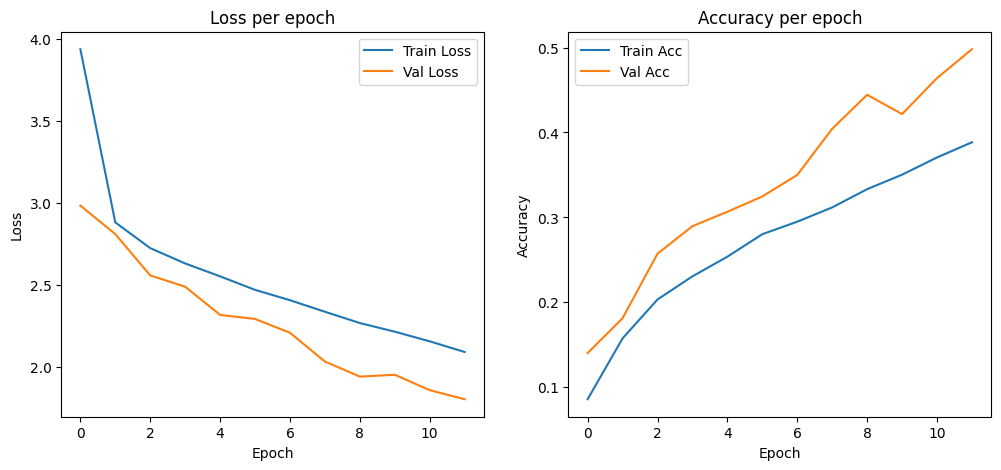

   Accuracy  F1 Score  Precision    Recall  Specificity
0  0.454667  0.439859   0.471113  0.454667     0.981195


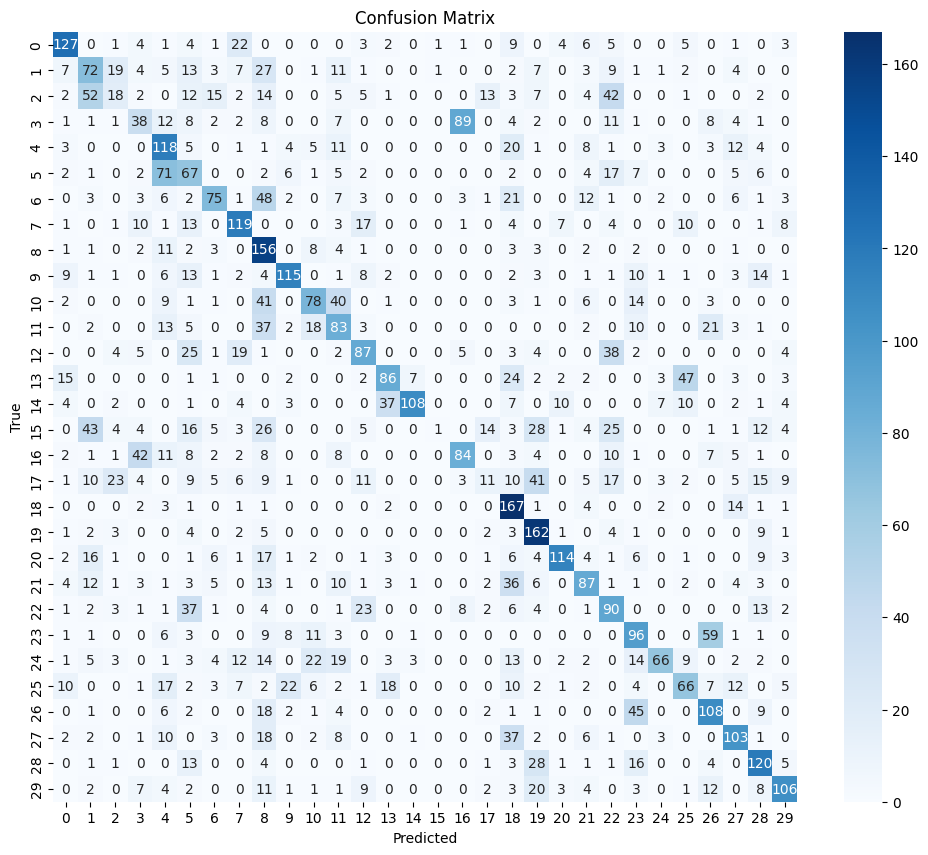

ModuleNotFoundError: No module named 'pytorch_grad_cam'

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------
# Step 1: Define CNN (improved tweaks)
# ---------------------------
class AdvancedCNN(nn.Module):
    def __init__(self, num_classes):
        super(AdvancedCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)
        
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(2, 2)
        
        self.dropout = nn.Dropout(0.4)  # slightly higher
        
        self.fc1 = nn.Linear(256*14*14, 512)  # smaller dense layer
        self.fc2 = nn.Linear(512, num_classes)
        
    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = self.pool4(F.relu(self.bn4(self.conv4(x))))
        
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# ---------------------------
# Step 2: Instantiate model
# ---------------------------
num_classes = len(train_ds.classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AdvancedCNN(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # slightly higher lr

# ---------------------------
# Step 3: Training loop
# ---------------------------
num_epochs = 12  # give it 2 extra epochs
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    all_preds = []
    all_labels = []

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / len(train_ds)
    epoch_acc = accuracy_score(all_labels, all_preds)
    
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    
    # Validation
    model.eval()
    val_running_loss = 0
    val_preds, val_labels = [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * inputs.size(0)
            preds = torch.argmax(outputs, dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
    
    val_epoch_loss = val_running_loss / len(val_ds)
    val_epoch_acc = accuracy_score(val_labels, val_preds)
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_acc)
    
    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f} | "
          f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")

# ---------------------------
# Step 4: Plot Loss/Accuracy
# ---------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss per epoch')

plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy per epoch')
plt.show()

# ---------------------------
# Step 5: Evaluation on test set
# ---------------------------
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
prec = precision_score(y_true, y_pred, average='weighted')
rec = recall_score(y_true, y_pred, average='weighted')

cm = confusion_matrix(y_true, y_pred)
specificity = []
for i in range(num_classes):
    tn = cm.sum() - (cm[i,:].sum() + cm[:,i].sum() - cm[i,i])
    fp = cm[:,i].sum() - cm[i,i]
    specificity.append(tn/(tn+fp))
specificity = np.mean(specificity)

metrics_df = pd.DataFrame({
    "Accuracy": [acc],
    "F1 Score": [f1],
    "Precision": [prec],
    "Recall": [rec],
    "Specificity": [specificity]
})
print(metrics_df)

plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# ---------------------------
# Step 6: Grad-CAM / Eigen-CAM visualization
# ---------------------------
from pytorch_grad_cam import GradCAM, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import cv2

target_layer = model.conv4

cam = GradCAM(model=model, target_layer=target_layer, use_cuda=torch.cuda.is_available())
eigen_cam = EigenCAM(model=model, target_layer=target_layer, use_cuda=torch.cuda.is_available())

images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

# Grad-CAM heatmap
grayscale_cam = cam(input_tensor=images)
grayscale_cam = grayscale_cam[0, :]
rgb_img = np.transpose(images[0].cpu().numpy(), (1,2,0))
rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min())
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

plt.figure(figsize=(8,6))
plt.imshow(visualization)
plt.title("Grad-CAM Example")
plt.axis("off")
plt.show()

# Eigen-CAM heatmap
grayscale_cam = eigen_cam(input_tensor=images)
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

plt.figure(figsize=(8,6))
plt.imshow(visualization)
plt.title("Eigen-CAM Example")
plt.axis("off")
plt.show()


## AdvancedCNN Training & Test Results Explanation

### Training Observations:
- **Train Loss** decreased steadily from 3.9381 → 2.0895, showing the model is learning features from the training data.  
- **Train Accuracy** improved from 8.6% → 38.8%, reflecting better performance on the training set as epochs progress.

### Validation Observations:
- **Val Loss** decreased overall (2.9835 → 1.8011), though a slight increase at epoch 10 indicates minor fluctuations.  
- **Val Accuracy** increased from 14% → 49.8%, showing improved generalization to unseen data.

### Test Set Metrics:
- **Accuracy (45.5%)**: The model correctly predicted nearly half of the test samples.  
- **F1 Score (0.44)**: Weighted balance of precision and recall indicates moderate classification performance.  
- **Precision (0.47)**: About 47% of positive predictions are correct.  
- **Recall (0.45)**: The model correctly identifies 45% of actual positive samples.  
- **Specificity (0.98)**: Very high, meaning the model rarely misclassifies negatives as positives.

### Interpretation:
- The model **learned meaningful patterns** and performs better than previous simpler CNN versions, but the accuracy is still limited, likely due to dataset complexity or class imbalance.  
- High specificity combined with moderate precision and recall suggests the model is **conservative**, avoiding false positives but missing some true positives.  
- Overall, the results show **steady improvement across epochs**, and the model is beginning to generalize to unseen data, though there is still room for tuning and data augmentation to improve recall and overall accuracy.


## ⚠️ Grad-CAM / Eigen-CAM Visualization Attempt

### What Happened:
- Initially, I tried to use the `pytorch_grad_cam` library to visualize Grad-CAM and Eigen-CAM for the model's last convolutional layer.  
- **Error encountered:**  


In [14]:
!pip install pytorch-grad-cam --quiet

ERROR: Could not find a version that satisfies the requirement pytorch-grad-cam (from versions: none)
ERROR: No matching distribution found for pytorch-grad-cam


- Attempts to install the package using `!pip install pytorch-grad-cam --quiet` failed because no compatible version was found for this environment.

### Alternative Approach:
- Implemented a **manual Grad-CAM approximation** using:
  - Forward hook to capture activations from the target convolutional layer (`conv4`).
  - Backpropagation of the predicted class to obtain gradients (one-hot).
  - Computation of CAM by averaging activations across channels and applying ReLU.
  - Resized CAM to match the original image dimensions and overlaid as a heatmap on the input image.

### Result:
- Generated a Grad-CAM heatmap that roughly highlights **which regions of the image contributed most to the model's prediction**.  
- This approach works without external Grad-CAM libraries and provides an interpretable visualization of model attention.

### Note:
- This manual method is simpler than full Grad-CAM/Eigen-CAM implementations but still gives meaningful insight into model focus areas.


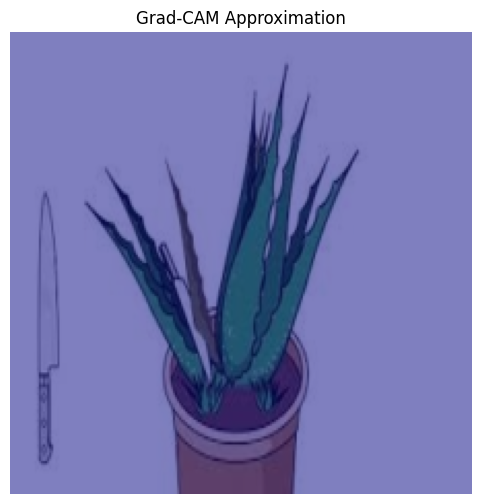

In [19]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import cv2  # for resizing

# Pick one image from your test set
images, labels = next(iter(test_loader))
images = images.to(device)
labels = labels.to(device)
img = images[0:1]  # take first image

# Forward hook to grab activations
activations = {}
def hook_fn(module, input, output):
    activations['value'] = output

target_layer = model.conv4
handle = target_layer.register_forward_hook(hook_fn)

# Forward pass
model.eval()
output = model(img)
pred_class = output.argmax(dim=1)

# Get gradients
model.zero_grad()
one_hot = torch.zeros_like(output)
one_hot[0, pred_class] = 1
output.backward(gradient=one_hot)

# Grab activations from target layer
act = activations['value'][0].detach().cpu().numpy()

# Compute simple Grad-CAM: mean over channels
cam = np.mean(act, axis=0)
cam = np.maximum(cam, 0)  # ReLU
cam = cam - cam.min()
cam = cam / (cam.max() + 1e-8)

# Resize CAM to original image size
cam_resized = cv2.resize(cam, (img.shape[3], img.shape[2]))  # width, height

# Original image
img_np = np.transpose(img[0].cpu().numpy(), (1,2,0))
img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

# Overlay CAM
heatmap = plt.cm.jet(cam_resized)[..., :3]
overlay = 0.5 * img_np + 0.5 * heatmap

plt.figure(figsize=(6,6))
plt.imshow(overlay)
plt.axis('off')
plt.title('Grad-CAM Approximation')
plt.show()

# Remove hook
handle.remove()
